In [2]:
import pandas as pd
import seaborn as sns
import glob
from numpy import genfromtxt
# from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
import numpy as np
# https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html
import json
from collections import OrderedDict
import os
import re
import logging
import multiprocessing
from functools import partial
from datetime import datetime
from Bio import SeqIO
from Bio.Seq import Seq
import gzip
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold

/data/hoan/mybin/miniconda3/envs/py36/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
try:
    %load_ext autoreload
    %autoreload 2
except Exception as e:
    logging.error(traceback.format_exc())

### Create map from gene ID to cluster ID

In [4]:
# panta input directory
# pantain_dir = '/data/hoan/amromics/prediction/data/Ecoli1936/prokkatest/'
pantain_dir = '/data/hoan/amromics/prediction/data/Ecoli1936/prokka/'
# panta output dir
# pantaout_dir = '/data/hoan/amromics/prediction/output/pantaEcoli1936aligntest/'
pantaout_dir = '/data/hoan/amromics/prediction/output/pantaEcoli1936align_v4/'

In [5]:
with open(pantaout_dir + 'annotated_clusters.json', 'r') as JSON:
    json_dict = json.load(JSON)
# data = json.loads('/data/hoan/amromics/prediction/output/pantaEcoli1936aligntest/clusters.json')[0]

In [6]:
print("TODO: AMR before and after AMR genes")

TODO: AMR before and after AMR genes


In [7]:
gene2clusterdict = {}
for key in json_dict:
    if len(json_dict[key])==0:
        gene2clusterdict[key] = key
    for gene in json_dict[key]['gene_id']:
        gene2clusterdict[gene] = key

### Find all AMR genes

In [7]:
from pangraph.utils import parse_gff_AMRgene_finder, parse_gff_AMRgene_finder_neighbors

In [8]:
def parse_gff_AMRgene_finder_neighbor_Kmer(fasta_dict, gff_fh, sample_id, sample_index, ksize, min_protein_len=40):
    seq_id = None
    min_cds_len = 3 * min_protein_len
    
    # tag_list = []
    amr_gene_list = []
    kmer_list = []
    pairdata = []
    for line in gff_fh:            
        if line.startswith('##FASTA'):
            #Done reading gff, move on to reading fasta
            break

        if line[0] == '#':
            continue
        line = line.strip()
        #print(line)
        cells = line.split('\t')
        if cells[2] != 'CDS':
            continue
        if 'BARRGD' not in cells[8]:
            continue
        start = int(cells[3])
        end = int(cells[4])
        length = end - start + 1
        if length < min_cds_len:
            continue
        if length % 3 != 0:
            continue
        contig_id = cells[0]
        cells[0] = cells[0].replace('-','_') #make sure seq_id has no -
        
        if seq_id != cells[0]:
            seq_id = cells[0]
            gene_index = 0

        # strand = cells[6]
        tags = cells[8].split(';')
        gene_id = None
        gene_name = ''
        gene_product = ''
        for tag in tags:
            if tag.startswith('ID='):
                gene_id = tag[3:]
            elif tag.startswith('gene='):                    
                gene_name = tag[5:]
                gene_name = re.sub(r'\W', '_', gene_name)
            elif tag.startswith('product='):                    
                gene_product = tag[8:]
        if gene_id == None:
            continue

        # Ensure gene_id is in the format of sample_id-seq_id-gene_tag
        if not gene_id.startswith(sample_id + '-'):
            gene_id = sample_id + '-' + gene_id

        if not gene_id.startswith(sample_id + '-' + seq_id + '-'):
            gene_id = sample_id + '-' + seq_id + '-' + gene_id[len(sample_id)+1:]
        
        # tag_list.append(cells[8])
        amr_gene_list.append(gene_id)
        
        subseq = fasta_dict[contig_id][max(0, start-500):start] 
        n_kmers = len(subseq) - ksize + 1
        for i in range(n_kmers):
            kmer = subseq[i:i + ksize]
            kmer_list.append(kmer)
        
        subseq = fasta_dict[contig_id][end:(end+500)]
        n_kmers = len(subseq) - ksize + 1
        for i in range(n_kmers):
            kmer = subseq[i:i + ksize]
            kmer_list.append(kmer)
    kmer_list = list(set(kmer_list))
    for kmer in kmer_list:
        pairdata.append((sample_index, kmer))
    return amr_gene_list, kmer_list, pairdata

In [19]:
with open(pantaout_dir + 'samples.json', 'r') as JSON:
    sample_dict = json.load(JSON)
sample2integerindex = {}
for idx in range(len(sample_dict)):
    sample2integerindex[sample_dict[idx]['id']] = idx
n_samples = len(sample_dict)

In [10]:
amr_gene = []; kmer_loci = []; pairdata_loci = []
# triple_amr = []
for data_dir in glob.glob(pantain_dir + '*.gff'):
    # read the fasta sequence.
    fasta_dict = {}
    fasta_sequences = SeqIO.parse(open(data_dir),'fasta')
    for fasta in fasta_sequences:
        name, sequence = fasta.id, str(fasta.seq)
        fasta_dict[name] = sequence

    # print(data_dir)
    in_fh = open(data_dir)
    sample_id = data_dir.split('/')[-1][:-4]
    sample_index = sample2integerindex[sample_id]
    ksize = 30
    amr_gene_list, kmer_list, pairdata = parse_gff_AMRgene_finder_neighbor_Kmer(fasta_dict, in_fh, sample_id, sample_index, ksize, min_protein_len=40)
    in_fh.close()
    amr_gene += amr_gene_list
    kmer_loci += kmer_list
    pairdata_loci += pairdata

In [11]:
# process loci
unique_kmer = list(set(kmer_loci))
kmer2index = {}
for i in range(len(unique_kmer)):
    kmer2index[unique_kmer[i]] = i
kmer_matrix_loci = np.zeros((n_samples, len(unique_kmer)))
for u, v in pairdata_loci:
    kmer_matrix_loci[u, kmer2index[v]] = 1

selector = VarianceThreshold(threshold=0.05)
kmer_matrix_loci_VT = selector.fit_transform(kmer_matrix_loci)

In [14]:
kmer_matrix_loci_VT.shape

(1653, 246015)

In [11]:
## AMR clusters
amr_clusterID = [gene2clusterdict[gene] for gene in amr_gene]
amr_clusterID = list(set(amr_clusterID))

In [16]:
amr_clusterID[:5], len(amr_clusterID)

(['oqxA6_4_14147', 'vanR_C', 'oqxB3_16395', 'oqxA6_4', 'tauB'], 464)

### Common cluster from matrix

In [17]:
# pa_matrix = pd.read_csv(pantaout_dir+'gene_presence_absence.Rtab', sep='\t', index_col=0).T
# n_samples = pa_matrix.shape[0]
# n_genes = pa_matrix.shape[1]
# colsum = pa_matrix.sum()
# common_gene_cluster = [colsum.index[idx] for idx in range(n_genes) if colsum[idx] > 0.99*n_samples]

### Compute label encoder for gene cluster

In [12]:
from pangraph.utils import binary_label
from sklearn.feature_selection import mutual_info_classif, chi2

In [8]:
pa_matrix = pd.read_csv(pantaout_dir+'gene_presence_absence.Rtab', sep='\t', index_col=0).T

In [14]:
all_gene_cluster = pa_matrix.columns.values

In [15]:
# computed_gene_cluster = common_gene_cluster; #amr_clusterID
# computed_gene_cluster = amr_clusterID;
# computed_gene_cluster = topfeaturesbypresenceabsence;
# computed_gene_cluster = topfeaturesbysimmat;
# computed_gene_cluster = unique_triple;
computed_gene_cluster = all_gene_cluster;

In [16]:
computed_gene_cluster[:10]

array(['groups_0', 'namA', 'groups_2', 'groups_3', 'groups_4', 'groups_5',
       'groups_6', 'groups_7', 'groups_8', 'groups_9'], dtype=object)

In [20]:
# amr_mat = None;
ksize = 10; # k = 10 for protein, 20 for DNA
kmer_list = [];
amr_mat = np.zeros((n_samples, len(computed_gene_cluster)))
pairdata = []
ratio_vec = []
for idx in range(len(computed_gene_cluster)):
    alignment_dir = pantaout_dir + 'clusters/' + computed_gene_cluster[idx] +'/'+computed_gene_cluster[idx]+'.faa.aln.gz'
    # alignment_dir = pantaout_dir + 'clusters/' + computed_gene_cluster[idx] +'/'+computed_gene_cluster[idx]+'.fna.aln.gz'
    with gzip.open(alignment_dir, "rt") as handle:
        count = 0;
        for record in SeqIO.parse(handle, "fasta"):
            name, sequence = record.id, str(record.seq)
            count += 1
            # sample_id = name.split('-')[0]
            # seqraw = sequence.replace('-', '')
            # n_kmers = len(seqraw) - ksize + 1
            # for i in range(n_kmers):
            #     kmer = seqraw[i:i + ksize]
            #     kmer_list.append(kmer)
            #     pairdata.append((sample2integerindex[sample_id], kmer))
        # print(count, n_samples, float(count)*100.0/n_samples)
        ratio_vec.append(float(count)*100.0/n_samples)

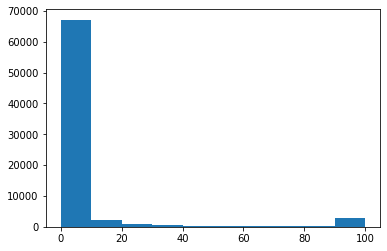

In [21]:
plt.hist(ratio_vec)
plt.show()

In [15]:
unique_kmer = list(set(kmer_list))

In [16]:
# AMR genes: (74198447, 169115)
len(kmer_list), len(unique_kmer)

(74198447, 169115)

In [23]:
kmer2index = {}
for i in range(len(unique_kmer)):
    kmer2index[unique_kmer[i]] = i

In [24]:
kmer_matrix = np.zeros((n_samples, len(unique_kmer)))

In [25]:
# ct = 0
for u, v in pairdata:
    # kmer_matrix[u, kmer2index[v]] += 1
    kmer_matrix[u, kmer2index[v]] = 1

In [26]:
kmer_matrix.shape

(1653, 169115)

In [27]:
selector = VarianceThreshold(threshold=0.05)
kmer_matrix_VT = selector.fit_transform(kmer_matrix)

In [28]:
kmer_matrix_VT.shape, kmer_matrix_loci_VT.shape

((1653, 33176), (1653, 246015))

In [29]:
combine_kmer_matrix = np.concatenate((kmer_matrix_VT, kmer_matrix_loci_VT), axis=1)

In [30]:
metadata_panta = pd.read_csv("data/Ecoli1936metafiles/metadata_final.csv")
mutual_mat = []
for idx in range(2, 14):
    y_class = metadata_panta.iloc[:,idx].values
    print(metadata_panta.columns[idx])
    y, nonenan_index = binary_label(y_class) # v6
    pa_matrix_new = combine_kmer_matrix[nonenan_index, ]
    y_new = y[nonenan_index].astype(int)
    scores, pvalue = chi2(pa_matrix_new, y_new)
    mutual_mat.append(scores)

CTZ
CTX
AMP
AMX
AMC
TZP
CXM
CET
GEN
TBM
TMP
CIP


In [31]:
mutual_mat = np.array(mutual_mat)
mutual_mat_mean = mutual_mat.mean(axis=0)
top_features = np.argsort(mutual_mat_mean)[::-1][:100000]
kmer_matrix_VT_top_features = combine_kmer_matrix[:,top_features]
kmer_matrix_VT_top_features.shape

(1653, 100000)

In [32]:
# np.save(pantaout_dir + 'kmer_amr_mat_VT1.npy', kmer_matrix_VT) # save numpy array
# np.save(pantaout_dir + 'kmer_coregene_mat_VT1.npy', kmer_matrix_VT) # save numpy array
# np.save(pantaout_dir + 'topfeaturesbypresenceabsence_VT5.npy', kmer_matrix_VT) # save numpy array
# np.save(pantaout_dir + 'topfeaturesbysimmat_VT5.npy', kmer_matrix_VT) # save numpy array
# np.save(pantaout_dir + 'kmer_amr_count_mat_VT1.npy', kmer_matrix_VT) # save numpy array
# np.save(pantaout_dir + 'kmer_amr_DNA_mat_VT5.npy', kmer_matrix_VT) # save numpy array
# np.save(pantaout_dir + 'kmer_amr_DNA_mat_VT5_top_features.npy', kmer_matrix_VT_top_features) # save numpy array
# np.save(pantaout_dir + 'kmer_amr_neighbors_mat_VT5_top_features.npy', kmer_matrix_VT_top_features) # save numpy array
# np.save(pantaout_dir + 'kmer_amr_neighbors_count_mat_VT5_top_features.npy', kmer_matrix_VT_top_features) # save numpy array
# np.save(pantaout_dir + 'combine_kmer_matrix_loci.npy', combine_kmer_matrix) # save numpy array
# np.save(pantaout_dir + 'combine_kmer_matrix_loci300.npy', combine_kmer_matrix) # save numpy array
# np.save(pantaout_dir + 'combine_kmer_matrix_loci300K30.npy', combine_kmer_matrix) # save numpy array
np.save(pantaout_dir + 'combine_kmer_matrix_loci300K30TwoSides.npy', kmer_matrix_VT_top_features) # save numpy array

In [33]:
stop

NameError: name 'stop' is not defined

In [ ]:

fasta_sequences = SeqIO.parse(open('/data/hoan/amromics/prediction/data/Ecoli1936/prokka/SAMEA2205716.contig.gff'),'fasta')
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    print(name)
    print(sequence[:20])

In [ ]:
fasta_sequences = SeqIO.parse(open('/data/hoan/amromics/prediction/data/Ecoli1936/SAMEA2205716.contig.fa'),'fasta')
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    print(name)
    print(sequence[:20])